In [1]:

import os
import pandas as pd
path_, filename_, category_, article_or_summary_ = [],[],[],[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path_.append(os.path.join(dirname, filename))
        filename_.append(filename)
        category_.append(dirname.split("/")[-1])
        article_or_summary_.append(dirname.split("/")[-2])

In [2]:
df = pd.DataFrame({"path":path_, "filename":filename_, "category":category_, "article_or_summary":article_or_summary_}, columns=["path", "filename", "category", "article_or_summary"])
df

,path,filename,category,article_or_summary
0,/kaggle/input/bbc-news-summary/BBC News Summar...,361.txt,politics,Summaries
1,/kaggle/input/bbc-news-summary/BBC News Summar...,245.txt,politics,Summaries
2,/kaggle/input/bbc-news-summary/BBC News Summar...,141.txt,politics,Summaries
3,/kaggle/input/bbc-news-summary/BBC News Summar...,372.txt,politics,Summaries
4,/kaggle/input/bbc-news-summary/BBC News Summar...,333.txt,politics,Summaries
...,...,...,...,...
8895,/kaggle/input/bbc-news-summary/bbc news summar...,380.txt,business,News Articles
8896,/kaggle/input/bbc-news-summary/bbc news summar...,192.txt,business,News Articles
8897,/kaggle/input/bbc-news-summary/bbc news summar...,248.txt,business,News Articles
8898,/kaggle/input/bbc-news-summary/bbc news summar...,004.txt,business,News Articles


In [3]:
!pip install cufflinks
import plotly_express as pe
import cufflinks as cf

cf.go_offline()

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.



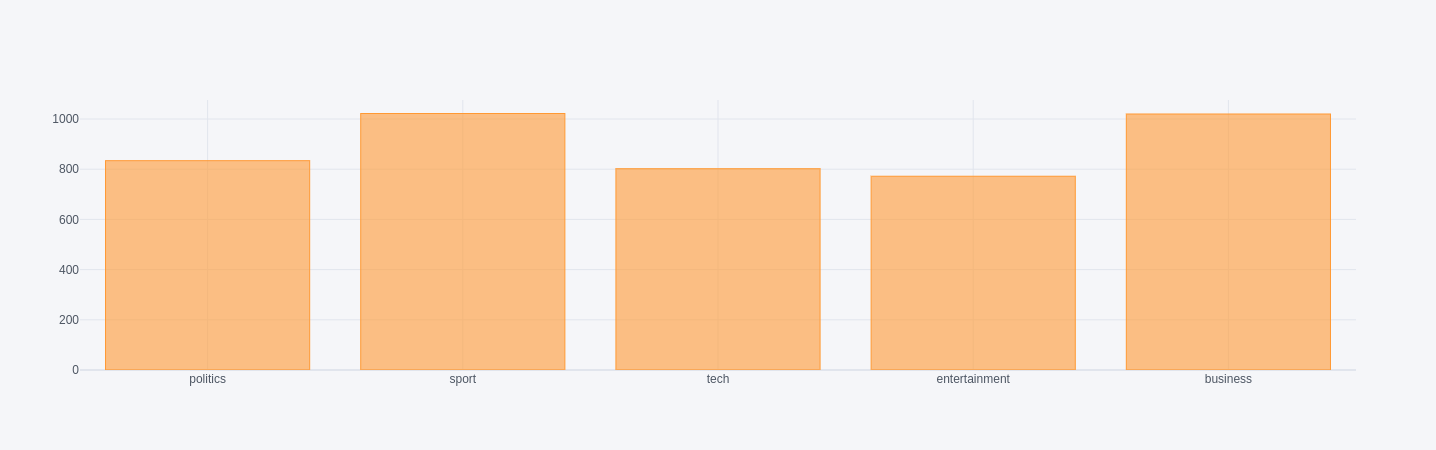

In [4]:
from collections import Counter

ct = Counter(df[df['article_or_summary']=="News Articles"]["category"])
pd.DataFrame({"category":ct.keys(), "value":ct.values()}).iplot(kind='bar', x='category', y='value')

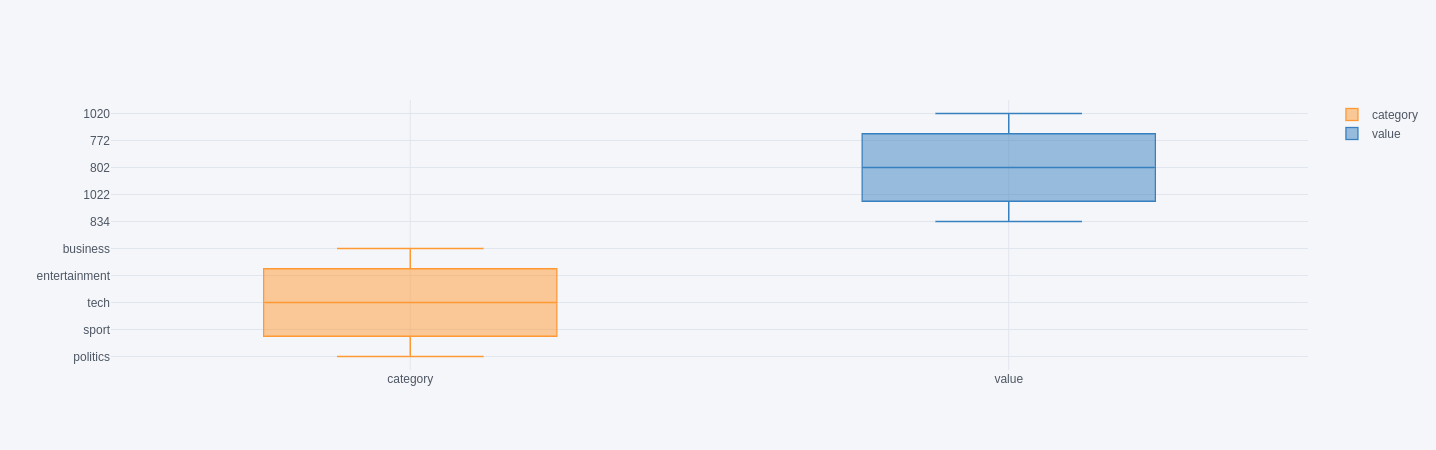

In [5]:
pd.DataFrame({"category":ct.keys(), "value":ct.values()}).iplot(kind='box')

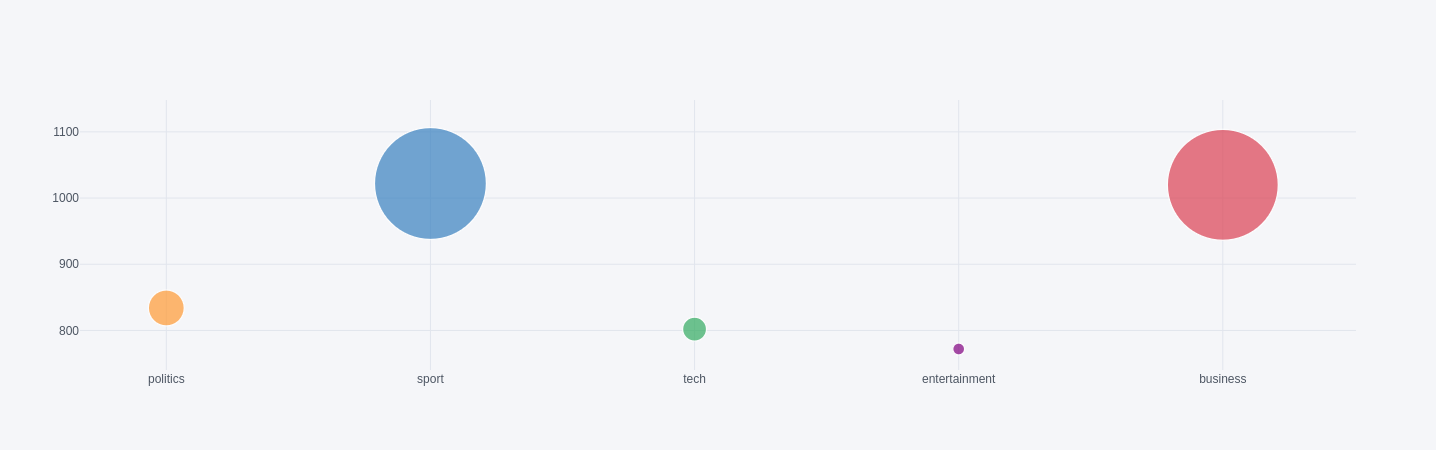

In [6]:
pd.DataFrame({"category":ct.keys(), "value":ct.values()}).iplot(kind='bubble', x='category', y='value', size='value')

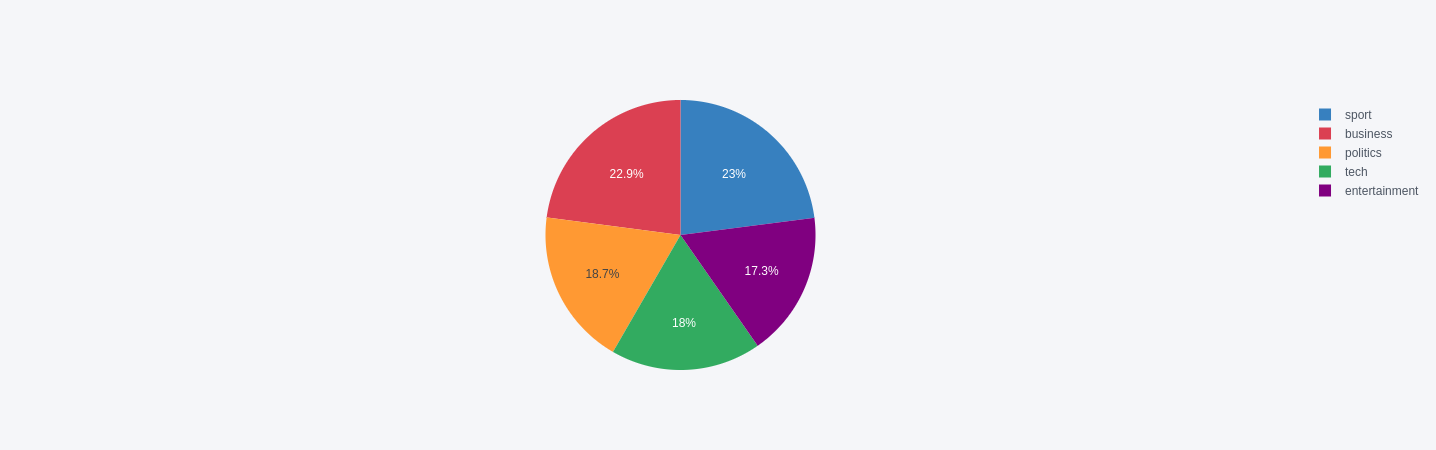

In [7]:
pd.DataFrame({"category":ct.keys(), "value":ct.values()}).iplot(kind='pie', labels="category", values='value')

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
import numpy as np
import networkx as nx
import re

In [9]:
def read_article(text):        
    sentences =[]        
    sentences = sent_tokenize(text)    
    for sentence in sentences:        
        sentence.replace("[^a-zA-Z0-9]"," ")     
    return sentences

In [10]:
file_path = df[df['article_or_summary']=='News Articles'].iloc[0]['path']
with open(file_path, "r") as f:
    article = f.read()

In [11]:
sent_tok = read_article(article)
sent_tok

["Budget to set scene for election\n\nGordon Brown will seek to put the economy at the centre of Labour's bid for a third term in power when he delivers his ninth Budget at 1230 GMT.",
 'He is expected to stress the importance of continued economic stability, with low unemployment and interest rates.',
 'The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from £60,000.',
 'But the Conservatives and Lib Dems insist voters face higher taxes and more means-testing under Labour.',
 'Treasury officials have said there will not be a pre-election giveaway, but Mr Brown is thought to have about £2bn to spare.',
 "- Increase in the stamp duty threshold from £60,000 \n - A freeze on petrol duty \n - An extension of tax credit scheme for poorer families \n - Possible help for pensioners The stamp duty threshold rise is intended to help first time buyers - a likely theme of all three of the main parties' general election manifestos.",
 'Ten years ago, buyers had a m

In [12]:
from textblob import TextBlob
mod_sent = []
for tok in sent_tok:
    blob_obj = TextBlob(tok)
    correct_sent = str(blob_obj.correct())
    print(f"\033[94m Original Token : {tok} \033[0m")
    print(f"\033[92m Corrected Token: {correct_sent} \033[92m")
    mod_sent.append(correct_sent)

 Original Token : Budget to set scene for election

Gordon Brown will seek to put the economy at the centre of Labour's bid for a third term in power when he delivers his ninth Budget at 1230 GMT. 
 Corrected Token: Budget to set scene for election

Gordon Grown will seek to put the economy at the centre of Labour's bid for a third term in power when he delivers his ninth Budget at 1230 GMT. 
 Original Token : He is expected to stress the importance of continued economic stability, with low unemployment and interest rates. 
 Corrected Token: He is expected to stress the importance of continued economic stability, with low unemployment and interest rates. 
 Original Token : The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from £60,000. 
 Corrected Token: The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from £60,000. 
 Original Token : But the Conservatives and Lib Dems insist voters face higher taxes and more means-te

In [13]:
" ".join(mod_sent)

'Budget to set scene for election\n\nGordon Grown will seek to put the economy at the centre of Labour\'s bid for a third term in power when he delivers his ninth Budget at 1230 GMT. He is expected to stress the importance of continued economic stability, with low unemployment and interest rates. The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from £60,000. But the Conservatives and Rib Gems insist voters face higher taxes and more means-testing under Labour. Treasury officials have said there will not be a pre-election giveaway, but Or Grown is thought to have about £in to spare. - Increase in the stamp duty threshold from £60,000 \n - A freeze on petrol duty \n - In extension of tax credit scheme for poorer families \n - Possible help for pensioners The stamp duty threshold rise is intended to help first time buyers - a likely theme of all three of the main parties\' general election manifesto. Men years ago, buyers had a much greater chance of avo

In [16]:
import tensorflow_hub as hub

embed = hub.Module("https://kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow1/variations/universal-sentence-encoder/versions/1")
# embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def sentence_similarity(sent1,sent2,embed):  
    A = embed([sent1])[0]
    B = embed([sent2])[0]
    return 1 - (np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B)))

URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

Sample Output of how the distance looks like between two sample Sentences

In [ ]:
print(f"\033[92m Sentence 1 : {mod_sent[0]}")
print(f"\033[92m Sentence 2 : {mod_sent[1]}")
print(f"\033[92m Similarity Score : {sentence_similarity(mod_sent[0], mod_sent[1], embed)}")

In [ ]:
def build_similarity_matrix(sentences,embeds):
    similarity_matrix = np.zeros((len(sentences),len(sentences)))
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1!=idx2:
                similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1],sentences[idx2],embeds)
    return similarity_matrix

In [ ]:
sim_mat = build_similarity_matrix(mod_sent, embed)

In [ ]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
import networkx
from bokeh.io import output_notebook, show, save

output_notebook()

g = nx.Graph()

for i in range(sim_mat.shape[0]):
    for j in range(sim_mat.shape[1]):
        if sim_mat[i][j] >=.9:
            g.add_edge(i, j)

HOVER_TOOLTIPS = [("sent_tok", "@index")]
plot = figure(tooltips = HOVER_TOOLTIPS, tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1))

network_graph = from_networkx(g, networkx.spring_layout, scale=7, center=(0, 0))
network_graph.node_renderer.glyph = Circle(size=15,fill_color='green')
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)
plot.renderers.append(network_graph)
show(plot)

In [ ]:
file_path_summary = df[df['article_or_summary']=='Summaries'].iloc[0]['path']
with open(file_path_summary, "r") as f:
    actual_summary = f.read()

In [ ]:
def generate_summary(text,top_n,embeds):
    summarize_text = []  
    sentences = read_article(text)           
    sentence_similarity_matrix = build_similarity_matrix(sentences,embeds)  
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_matrix)
    scores = nx.pagerank(sentence_similarity_graph) 
    ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)),reverse=True)
    for i in range(top_n):
        summarize_text.append(ranked_sentences[i][1]) 
    return " ".join(summarize_text)

In [ ]:
Original_Text = " ".join(mod_sent)
Summarized_Text = generate_summary(Original_Text, top_n=5, embeds=embed)

In [ ]:
Original_Text

In [ ]:
Summarized_Text

In [ ]:
actual_summary

In [ ]:
import nltk

hypothesis = Summarized_Text
reference = actual_summary
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(f"BLEUscore : {BLEUscore}")

In [ ]:
print(f"Senetence Similarity Score : {sentence_similarity(Summarized_Text, actual_summary, embed)}")

In [ ]:
!pip install  sumy
import sumy
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

In [ ]:
# For Strings
parser = PlaintextParser.from_string(Original_Text,Tokenizer("english"))

summarizer = LexRankSummarizer()
#Summarize the document with 2 sentences
summary = summarizer(parser.document, 5)

for sentence in summary:
    print(sentence)